<a href="https://colab.research.google.com/github/liviaferne/GANs-fashion-mnist/blob/main/notebooks/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks
> As Redes Adversariais Generativas (GANs) são aplicações de aprendizado profundo em que dois modelos de redes neurais — o gerador e o discriminador — são treinados simultaneamente em um processo competitivo. O gerador tem como objetivo produzir dados sintéticos (por exemplo, imagens) que se aproximem o máximo possível dos dados reais, enquanto o discriminador busca distinguir entre amostras reais e falsas.
>
>Essa dinâmica de competição promove um aprendizado adversarial, no qual o gerador melhora continuamente sua capacidade de enganar o discriminador, e este, por sua vez, aprimora sua habilidade de categorizar os dados. Desta forma, o desempenho ideal é alcançado através do equilíbrio de aprendizado entre ambos os modelos, mantendo o desafio e possibilidade de geração de amostras cada vez mais realistas.



## **1. Importação de bibliotecas**

In [ ]:
# Bibliotecas para construção dos modelos
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Bibliotecas auxiliares
import matplotlib.pyplot as plt
import numpy as np
import time

# Bibliotecas para gerar GIF
import os
import PIL
from PIL import Image
from IPython import display

<br>

## **2. Importação do dataset Fashion MNIST**

> Dataset gratuito de imagens de roupas (em escala de cinza) separadas em 10 categorias. A base é dividida em 60.000 imagens para treinamento e 10.000 para teste.

Cada item é uma matriz 28x28 pixels com valores entre 0 e 255 (tons de cinza).

In [ ]:
dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


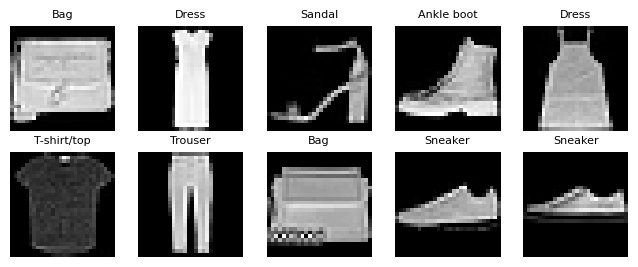

In [ ]:
# Indice e rotulo: 0. T-shirt/top / 1. Trouser / 2. Pullover / 3. Dress / 4. Coat / 5. Sandal / 6. Shirt / 7. Sneaker / 8. Bag / 9. Ankle boot
rotulos = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
indices = np.random.choice(len(train_images), size=10, replace=False)

# Exemplo dos dados de Fashion MNIST - Imagens "reais"
plt.figure(figsize=(8,3))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(train_images[indices[i]], cmap='gray')
  plt.title(rotulos[train_labels[indices[i]]], fontsize=8) # label
  plt.axis('off')
plt.show()

<br>

## **3. Ajuste dos dados**  



- Inicialmente, adiciona-se um canal de cor cinza (valor 1) às imagens, adequando-as ao formato esperado para as redes convolucionais. Os valores dos pixels são então convertidos para float (precisão nos cálculos) e depois normalizados na faixa [-1,1] (para estabilidade de treinamento dos modelos).

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

- Em seguida, são criados dois conjuntos de dados do TensorFlow - **train_dataset1** (para o Vanilla GAN) e **train_dataset2** (para o DCGAN).

- Os dados são embaralhados e divididos em lotes de 256 imagens, a fim de evitar que as redes aprendam padrões indesejados referente à ordem original dos dados.

In [ ]:
# Conversão dos dados para formato TensorFlow
train_dataset1 = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset2 = tf.data.Dataset.from_tensor_slices(train_images)

# Geração de lotes embaralhados
train_dataset1 = train_dataset1.shuffle(train_images.shape[0]).batch(256)
train_dataset2 = train_dataset2.shuffle(train_images.shape[0]).batch(256)

<br>

## **4. Funções de perda e otimizadores**

**Cálculo da entropia cruzada binária**: mede a diferença entre o que o modelo prediz e o que é real.
- **No discriminador**: soma das perdas para imagens reais e geradas (quanto menor, melhor a distinção).
- **No gerador**: mede o quanto ele engana o discriminador (quanto menor, melhor o engano).


In [ ]:
# Entropia cruzada binária
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

# Perda do discriminador
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output);
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output);
  d_loss = real_loss + fake_loss
  return d_loss

# Perda do gerador
def generator_loss(fake_output):
  g_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return g_loss

**Adam optimizer**

Otimizador adaptativo que ajusta a taxa de aprendizado por parâmetro e combina Momentum e RMSProp para uma convergência mais rápida e estável.

In [ ]:
#ger_otm = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
#disc_otm = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

<br>

## **5. Funções de treino e parâmetros**

In [ ]:
# Parâmetros de treinamento
num_epochs = 10
tam_ruido = 100
num_imagens_geradas = 16

# Seed
seed = tf.random.normal((num_imagens_geradas, tam_ruido))

###**Função train_steps**
- Executa uma etapa de treinamento GAN em um pequeno lote de imagens reais.
- O forward pass realiza a propagação dos dados pelos modelos gerador e discriminador, produzindo as predições.
- O processo de backpropagation ajusta os pesos dos modelos com base nos gradientes calculados, reduzindo o erro e aprimorando o aprendizado adversarial.

In [ ]:
def train_steps(lote_imagens_reais, gerador, discriminador, ger_otm, disc_otm, tam_ruido):
  ruido = tf.random.normal([len(lote_imagens_reais), tam_ruido])

  # Rastreamento automático de gradientes
  with tf.GradientTape() as gtape, tf.GradientTape() as dtape:
    # ----- Forward pass -----
    # Gerador - transforma ruído em imagem sintética 28x28x1
    imagens_geradas = gerador(ruido, training=True)
    # Discriminador - avalia imagens reais e geradas
    real_output = discriminador(lote_imagens_reais, training=True)
    fake_output = discriminador(imagens_geradas, training=True)
    # Cálculo das perdas
    g_loss = generator_loss(fake_output)
    d_loss = discriminator_loss(real_output, fake_output)

  # ----- Backpropagation -----
  # Gradientes e atualização dos pesos
  g_gradiente = gtape.gradient(g_loss, gerador.trainable_variables)
  d_gradiente = dtape.gradient(d_loss, discriminador.trainable_variables)
  ger_otm.apply_gradients(zip(g_gradiente, gerador.trainable_variables))
  disc_otm.apply_gradients(zip(d_gradiente, discriminador.trainable_variables))

  return g_loss, d_loss

###**Função treinamento**
- Executa o ciclo completo de treinamento da GAN: para cada época, percorre o lote de imagens, realiza o forward pass e o backpropagation via train_steps, calcula as perdas médias e salva as imagens falsas do gerador.
- Ao final, retorna as perdas médias do gerador e do discriminador ao longo das épocas.

In [ ]:
def treinamento(train_dataset, gerador, discriminador, ger_otm, disc_otm):
  media_perda_gerador = []
  media_perda_discriminador = []

  for epoch in range(num_epochs):
    start = time.time()

    perdas_gerador = []
    perdas_discriminador = []

    # Treinamento em lotes (batch size = 256)
    for lote_treino in train_dataset:
      g_lote_perda, d_lote_perda = train_steps(
          lote_treino,
          gerador,
          discriminador,
          ger_otm,
          disc_otm,
          tam_ruido
      )
      perdas_gerador.append(g_lote_perda)
      perdas_discriminador.append(d_lote_perda)

    # Cálculo das médias de perda por época
    mediag = tf.reduce_mean(perdas_gerador)
    mediad = tf.reduce_mean(perdas_discriminador)
    media_perda_gerador.append(mediag)
    media_perda_discriminador.append(mediad)

    # Geração e salvamento de amostras ao final da época
    salva_imagens(gerador, epoch+1, seed)

    # Exibe tempo de execução
    display.clear_output(wait=True)
    print("Epoch ", (epoch+1), ": ", (time.time()-start), " segundos")

  return media_perda_gerador, media_perda_discriminador

<br>

## **6. Funções auxiliares**

- Função para gerar gráfico de desempenho (perda discriminador x gerador) após o treinamento dos modelos.

In [ ]:
# Gráfico de perda discriminador x gerador
def grafico_desempenho(media_perda_gerador, media_perda_discriminador):
  epochs = range(1, num_epochs+1)
  plt.figure(figsize=(6,3))
  plt.plot(epochs, media_perda_gerador, label="Perda do gerador")
  plt.plot(epochs, media_perda_discriminador, label="Perda do discriminador")
  plt.legend()
  plt.grid()
  plt.title("Perdas do gerador x discriminador ao longo do treinamento")
  plt.xlabel("Epoch")
  plt.ylabel("Perda total")
  plt.show()

- Função para ajustar e salvar as imagens geradas durante o treinamento do modelo gerador - para criação do GIF final.

In [ ]:
diretorio = "sample_data/imagens_geradas"
if not os.path.exists(diretorio):
  os.mkdir(diretorio)

# Função para ajustar e salvar imagens
def salva_imagens(modelo, epoch, test_input):
  # Obtém as imagens geradas - matriz (16, 28, 28, 1)
  predictions = modelo(test_input, training=False)

  # Imagem única que contém as 16 imagens geradas na epoch
  plt.figure(figsize=(6, 6))
  for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.suptitle(f"Epoch {epoch}")
  plt.savefig(os.path.join(diretorio, f"imagem_{epoch}.png"))
  plt.close()

<br>

## **7. Aplicação de Vanilla GAN**


### **Construção dos modelos**


**Modelo do gerador Vanilla GAN**
- O gerador recebe um vetor de ruído (100 dimensões) e produz uma imagem 28x28x1. A estrutura é composta por camadas densas com ativação LeakyReLU e saída tanh.

In [ ]:
# Modelo do gerador (Vanilla GAN)
def build_simple_generator():
  model = keras.Sequential()

  # Camada de entrada: vetor de ruído (latent space)
  model.add(layers.InputLayer(shape=(100,)))

  # Camada densa 1
  model.add(layers.Dense(128, use_bias=True))
  model.add(layers.LeakyReLU())

  # Camada densa 2
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU())

  # Camada densa 3
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU())

  # Camada de saída: gera imagem 28x28x1 (escala [-1, 1])
  model.add(layers.Dense((28*28*1), activation='tanh'))
  model.add(layers.Reshape((28, 28, 1)))

  return model


# Instancia o gerador
gerador_vanilla = build_simple_generator()

**Modelo do discriminador Vanilla GAN**
- O discriminador recebe uma imagem 28x28x1 e retorna uma probabilidade da imagem ser gerada (0) ou real (1). A estrutura é composta por camadas densas com ativação LeakyReLU e regularização via Dropout.

In [ ]:
# Modelo do discriminador (Vanilla GAN)
def build_simple_discriminator():
  model = keras.Sequential()

  # Camada de entrada: imagem 28x28x1 (escala [-1, 1])
  model.add(layers.InputLayer(shape=(28, 28, 1)))
  model.add(layers.Flatten()) # Converte imagem em vetor unidimensional

  # Camada oculta 1
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3)) # Reduz overfitting desativando 30% das unidades

  # Camada oculta 2
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Camada oculta 3
  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Camada de saída: probabilidade de ser "real" (sigmoid ∈ [0, 1])
  model.add(layers.Dense(1, activation='sigmoid'))

  return model


# Instancia o discriminador
discriminador_vanilla = build_simple_discriminator()

<br>

### **Treinamento dos modelos**

In [ ]:
# Libera memória de sessões anteriores do TensorFlow
keras.backend.clear_session(free_memory=True)

# Reinicializa os otimizadores para cada treinamento
ger_otm_vanilla = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_otm_vanilla = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Executa o treinamento da Vanilla GAN
media_perda_gerador_vanilla, media_perda_discriminador_vanilla = treinamento(
    train_dataset1,
    gerador_vanilla,
    discriminador_vanilla,
    ger_otm_vanilla,
    disc_otm_vanilla
)

<br>

### **Resultados**

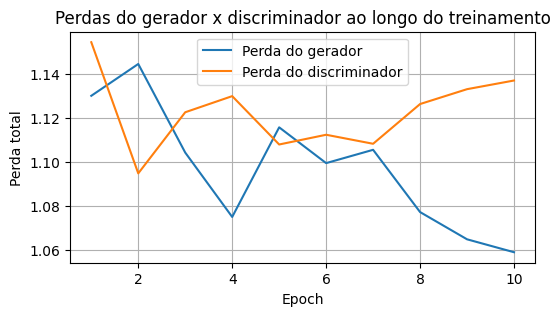

In [ ]:
grafico_desempenho(media_perda_gerador_vanilla, media_perda_discriminador_vanilla)

Neste Vanilla GAN, treinado por apenas 10 épocas em uma aplicação simples, a pequena variação das perdas ao longo do treinamento sugere um equilíbrio relativo entre os modelos. O gerador começou a produzir amostras mais realistas, enquanto o discriminador ainda consegue distinguir parcialmente as amostras reais e falsas. Nenhum modelo domina o outro, permitindo que ambos continuem competitivos e aprimorando suas capacidades simultaneamente. Para reduzir os valores de perda, seria necessário um treinamento mais prolongado e robusto.

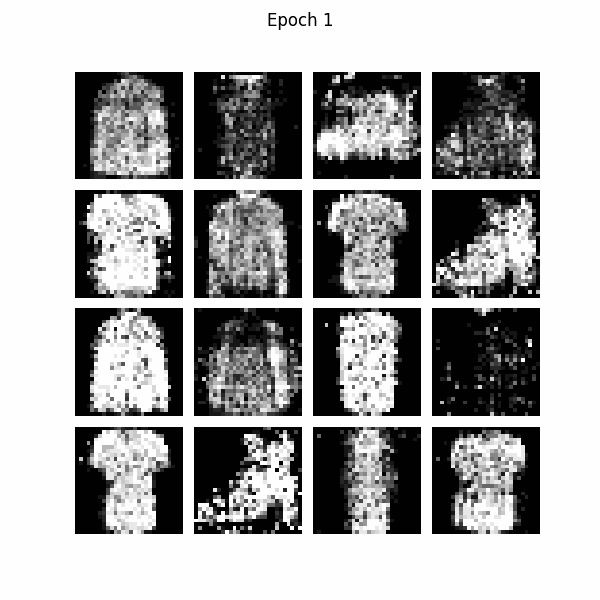

In [ ]:
# GIF com as imagens geradas pelo gerador
imagens = []
for i in range(num_epochs):
  imagens.append(Image.open(f"{diretorio}/imagem_{i+1}.png"))
imagens[0].save("imagem_GIF.gif", format='GIF', save_all=True,
                append_images=imagens[1:], duration=500, loop=0)
display.Image(filename="imagem_GIF.gif")

<br><br>

## **8. Aplicação de DCGAN**


### **Construção dos modelos**


**Modelo do gerador DCGAN**
- O gerador recebe um vetor de ruído (100 dimensões) e produz uma imagem 28x28x1. Ele faz uso de camadas deconvolucionais (Conv2DTranspose) com Batch Normalization e LeakyReLU, que reconstroem progressivamente o espaço da imagem e permitem gerar amostras mais realistas e com melhor qualidade espacial.

In [ ]:
# Modelo do gerador (DCGAN)
def build_dcgan_generator():
  model = keras.Sequential()

  # Camada de entrada: vetor de ruído (latent space)
  model.add(layers.InputLayer(shape=(100,)))

  # Camada totalmente conectada + reestruturação em mapa de ativação 7x7x128
  model.add(layers.Dense(7*7*128, use_bias=True))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Reshape((7, 7, 128)))
  assert model.output_shape == (None, 7, 7, 128) # Verificação de formato

  # Camada deconvolucional 1
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1),
                                   padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Camada deconvolucional 2
  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2),
                                   padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Camada de saída: gera imagem 28x28x1 (escala [-1, 1])
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                   use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model


# Instancia o gerador
gerador_dcgan = build_dcgan_generator()

**Modelo do discriminador DCGAN**
- O discriminador recebe uma imagem 28x28x1 e retorna uma probabilidade indicando se a imagem é gerada (0) ou real (1). Utiliza camadas convolucionais com LeakyReLU e regularização por Dropout, o que torna a distinção entre as imagens geradas e reais mais estável e robusta.

In [ ]:
# Modelo do discriminador (DCGAN)
def build_dcgan_discriminator():
  model = keras.Sequential()

  # Camada de entrada: imagem 28x28x1 (escala [-1, 1])
  model.add(layers.InputLayer(shape=(28, 28, 1)))

  # Camada convolucional 1
  model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3)) # Reduz overfitting desativando 30% das unidades

  # Camada convolucional 2
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Camada de saída: probabilidade de ser "real" (sigmoid ∈ [0, 1])
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model


# Instancia o discriminador
discriminador_dcgan = build_dcgan_discriminator()

<br>

### Treinamento dos modelos

In [ ]:
# Libera memória de sessões anteriores do TensorFlow
keras.backend.clear_session(free_memory=True)

# Reinicializa os otimizadores para cada treinamento
ger_otm_dcgan = keras.optimizers.Adam(learning_rate=7e-5, beta_1=0.5)
disc_otm_dcgan = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Executa o treinamento do DCGAN
media_perda_gerador_dcgan, media_perda_discriminador_dcgan = treinamento(
    train_dataset2,
    gerador_dcgan,
    discriminador_dcgan,
    ger_otm_dcgan,
    disc_otm_dcgan
)

<br>

### **Resultados**

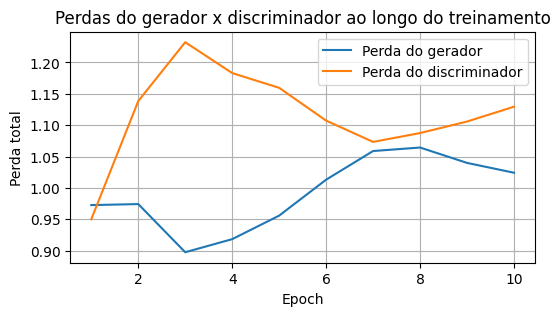

In [ ]:
grafico_desempenho(media_perda_gerador_dcgan, media_perda_discriminador_dcgan)

Nos casos testados para o DCGAN, o gerador estava aprendendo muito mais rápido que o discriminador, dominando-o. Um ajuste feito para contornar o problema foi diminuir o learning rate do gerador para que ele aprendesse um pouco mais lentamente. No caso acima, a perda do discriminador mantém-se alta no começo e a do gerador mais baixa, mas depois elas convergem. Desta forma, o equilíbrio relativo entre os modelos se mantém, assim o gerador continua gerando imagens cada vez melhores e o discriminador ainda consegue distinguir parcialmente as imagens reais das falsas.

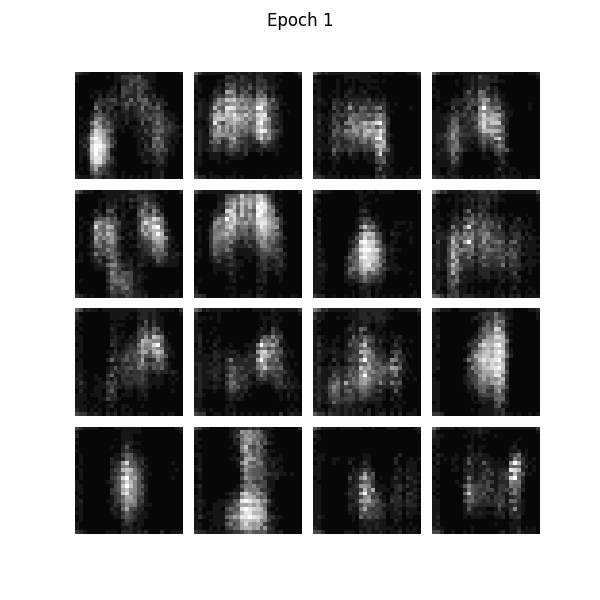

In [ ]:
# GIF com as imagens geradas pelo gerador
imagens = []
for i in range(num_epochs):
  imagens.append(Image.open(f"{diretorio}/imagem_{i+1}.png"))
imagens[0].save("imagem_GIF.gif", format='GIF', save_all=True, append_images=imagens[1:], duration=500, loop=0)
display.Image(filename="imagem_GIF.gif")

<br><br>

# **Referências**

- [Idiot Developer - Vanilla GAN in TensorFlow](https://idiotdeveloper.com/vanilla-gan-in-tensorflow/)  
- [TensorFlow - DCGAN Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan?hl=pt-br)  
- [Fashion MNIST Dataset](https://www.tensorflow.org/tutorials/keras/classification?hl=pt-br)


